In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
from scipy.ndimage import gaussian_filter
from scipy.ndimage import median_filter
from PIL import Image
import io
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import pandas as pd
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import random_split, Subset
from torch.utils.data import DataLoader


In [2]:
########################################################################################

# DEFINICJE

########################################################################################


######## ATAKI ########

def fgsm_attack(model, device, data, target, epsilon):
    # Generuje dane adwersarialne poprzez dodanie zakłóceń do oryginalnych danych wejściowych
    # Zakłócenia są proporcjonalne do znaku gradientu straty względem danych wejściowych, skalowane przez parametr epsilon
    data.requires_grad = True
    output = model(data)
    loss = torch.nn.functional.cross_entropy(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    perturbed_data = data + epsilon * data_grad.sign()
    perturbed_data = torch.clamp(perturbed_data, 0, 1)
    return perturbed_data


def pgd_attack(model, device, data, target, epsilon=0.3, alpha=0.01, iters=40):
    perturbed_data = data.clone().detach().to(device)
    perturbed_data.requires_grad = True

    for i in range(iters):
        output = model(perturbed_data)
        loss = F.cross_entropy(output, target)
        model.zero_grad()
        loss.backward()
        grad = perturbed_data.grad.data

        # Krok w kierunku gradientu
        perturbed_data = perturbed_data + alpha * grad.sign()

        # Projekcja do dozwolonego przedziału (epsilon-ball)
        perturbation = torch.clamp(perturbed_data - data, min=-epsilon, max=epsilon)
        perturbed_data = torch.clamp(data + perturbation, min=0, max=1).detach_()
        perturbed_data.requires_grad = True

    return perturbed_data


######## OBRONY ########

def apply_gaussian_blur(tensor_img, sigma=0.5):
    # Aplikuje rozmycie Gaussa do obrazu, co może pomóc w usuwaniu zakłóceń adwersarialnych.
    np_img = tensor_img.squeeze().detach().cpu().numpy()
    blurred = gaussian_filter(np_img, sigma=sigma)
    return torch.tensor(blurred).unsqueeze(0).to(tensor_img.device)

def reduce_bit_depth(tensor_img, bits=4):
    # Redukuje liczbę poziomów intensywności pikseli (np. do 5-bitowej głębi), co może wygładzać zakłócenia adwersarialne.
    levels = 2 ** bits
    return torch.round(tensor_img * (levels - 1)) / (levels - 1)

def apply_median_filter(tensor_img, size=1):
    # Aplikuje filtr medianowy, który usuwa szum poprzez zastąpienie wartości piksela medianą jego sąsiadów
    np_img = tensor_img.squeeze().detach().cpu().numpy()
    filtered = median_filter(np_img, size=size)
    return torch.tensor(filtered).unsqueeze(0).to(tensor_img.device)

def apply_jpeg_compression(tensor_img, quality=20):
    # Kompresuje obraz do formatu JPEG z określoną jakością (np. quality=30), co może usunąć drobne zakłócenia
    np_img = tensor_img.squeeze().detach().cpu().numpy() * 255
    pil_img = Image.fromarray(np_img.astype('uint8'))
    buffer = io.BytesIO()
    pil_img.save(buffer, format='JPEG', quality=quality)
    buffer.seek(0)
    compressed = Image.open(buffer)
    compressed = transforms.ToTensor()(compressed)
    return compressed.to(tensor_img.device)


######## MODELE SIECI ########
"""
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # Warstwa konwolucyjna 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # (batch, 1, 28, 28) -> (batch, 32, 28, 28)
        # Warstwa konwolucyjna 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # (batch, 32, 28, 28) -> (batch, 64, 28, 28)
        
        # Warstwa w pełni połączona (po flatten)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 klas (cyfry 0-9)

        # Max pooling
        self.pool = nn.MaxPool2d(2, 2)  # zmniejszenie wymiarów o 2x

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> (batch, 32, 14, 14)
        x = self.pool(F.relu(self.conv2(x)))  # -> (batch, 64, 7, 7)
        x = x.view(-1, 64 * 7 * 7)            # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class AdvTrainedCNN(SimpleCNN):
    def __init__(self):
        super().__init__()  # dziedziczy architekturę SimpleCNN

"""

######## FUNKCJE TESTOWE ########
"""
def test(model, device, test_loader):   #unkcja ocenia model na danych adwersarialnych
    # Modele są testowane na danych testowych MNIST, a dokładność jest zapisywana
    # na danych czystych
    model.eval()
    correct = 0
    test_loss = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)      # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({acc:.2f}%)\n')
    return acc
"""

def test(model, device, loader):
    model.eval()
    correct = 0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    dataset_size = len(loader.dataset)
    accuracy = 100. * correct / dataset_size

    return accuracy

def test_adversarial(model, device, test_loader, epsilon, defense=None, attack_type='fgsm'):
    # Generuje dane adwersarialne za pomocą fgsm_attack
    # Opcjonalnie stosuje jedną z metod obrony (np. Gaussian Blur, Bit-depth Reduction, Median Filtering, JPEG Compression)
    # Oblicza dokładność modelu na danych adwersarialnych
    model.eval()
    correct = 0
    
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        # Generuj dane adwersarialne
        if attack_type == 'fgsm':
            perturbed_data = fgsm_attack(model, device, data, target, epsilon)
        elif attack_type == 'pgd':
            perturbed_data = pgd_attack(model, device, data, target, epsilon, alpha=epsilon/4, iters=10)

        # Zastosuj metodę obrony (jeśli wybrana)
        if defense == 'blur':
            perturbed_data = torch.stack([apply_gaussian_blur(img) for img in perturbed_data])
        elif defense == 'bit':
            perturbed_data = reduce_bit_depth(perturbed_data, bits=1)
        elif defense == 'median':
            perturbed_data = torch.stack([apply_median_filter(img) for img in perturbed_data])
        elif defense == 'jpeg':
            perturbed_data = torch.stack([apply_jpeg_compression(img) for img in perturbed_data])


        # Przepuść przez model
        output = model(perturbed_data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    acc = 100. * correct / len(test_loader.dataset)
    print(f'[{attack_type.upper()}] ε={epsilon:.2f} | Obrona: {defense or "brak"} | Acc: {acc:.2f}%')
    return acc



######## FUNKCJE TRENINGOWE ########
"""
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    running_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}')
    
    print(f'Epoch {epoch} finished with avg loss: {running_loss / len(train_loader):.6f}')
"""

def train(model, device, train_loader, optimizer, criterion, epochs):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Oblicz trafność predykcji w batchu
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

        avg_loss = total_loss / len(train_loader)
        train_acc = 100. * correct / total

        # Dokładność na zbiorze testowym
        test_acc = test(model, device, test_loader)
        train_losses.append(avg_loss)
        test_accuracies.append(test_acc)


        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Train Acc: {train_acc:.2f}% - Test Acc: {test_acc:.2f}%")

"""
def train_adversarial(model, device, train_loader, optimizer, epoch, epsilon=0.1):
    model.train()
    running_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Tworzymy dane adwersarialne
        adv_data = fgsm_attack(model, device, data, target, epsilon)

        # Łączymy dane czyste i adwersarialne
        mixed_data = torch.cat([data, adv_data], dim=0)
        mixed_target = torch.cat([target, target], dim=0)

        optimizer.zero_grad()
        output = model(mixed_data)
        loss = criterion(output, mixed_target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f'[Adversarial] Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}')
    
    print(f'[Adversarial] Epoch {epoch} finished. Avg loss: {running_loss / len(train_loader):.6f}')
"""
def train_adversarial(model, device, train_loader, optimizer, epoch, epsilon=0.1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Generuj dane adwersarialne
        adv_data = fgsm_attack(model, device, data, target, epsilon)

        # Łącz dane czyste i adwersarialne
        mixed_data = torch.cat([data, adv_data], dim=0)
        mixed_target = torch.cat([target, target], dim=0)

        optimizer.zero_grad()
        output = model(mixed_data)
        loss = F.cross_entropy(output, mixed_target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Oblicz trafność na batchu
        pred = output.argmax(dim=1)
        correct += pred.eq(mixed_target).sum().item()
        total += mixed_target.size(0)

        if batch_idx % 100 == 0:
            acc_batch = 100. * correct / total
            print(f'[Adv Train] Epoch {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] '
                  f'Loss: {loss.item():.6f} | Batch Acc: {acc_batch:.2f}%')

    avg_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    print(f'[Adv Train] Epoch {epoch} finished. Avg Loss: {avg_loss:.6f} | Avg Acc: {train_acc:.2f}%')



######## WIZUALIZACJA ########

def visualize_attack_and_defense(model, device, epsilon, defense=None, attack_type='fgsm'):
    model.eval()

    # Pobierz jedną próbkę z test_loadera
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    image = images[0].unsqueeze(0).to(device)  # pojedynczy obrazek [1, 1, 28, 28]
    label = labels[0].unsqueeze(0).to(device)

    # Obraz oryginalny
    original = image.clone()

    # Aplikuj atak
    if attack_type == 'fgsm':
        perturbed = fgsm_attack(model, device, image, label, epsilon)
    elif attack_type == 'pgd':
        perturbed = pgd_attack(model, device, image, label, epsilon, alpha=epsilon/4, iters=10)

    # Aplikuj obronę
    if defense == 'blur':
        defended = torch.stack([apply_gaussian_blur(img) for img in perturbed])
    elif defense == 'bit':
        defended = reduce_bit_depth(perturbed, bits=1)
    else:
        defended = perturbed.clone()

    # Przenieś na CPU do rysowania
    original_img = original.squeeze().detach().cpu().numpy()
    perturbed_img = perturbed.squeeze().detach().cpu().numpy()
    defended_img = defended.squeeze().detach().cpu().numpy()

    plt.figure(figsize=(10, 3))

    plt.subplot(1, 3, 1)
    plt.imshow(original_img, cmap="gray")
    plt.title("Oryginalny") 
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(perturbed_img, cmap="gray")
    plt.title(f"Atak (ε={epsilon})")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(defended_img, cmap="gray")
    plt.title(f"Po obronie: {defense or 'brak'}")
    plt.axis("off")

    plt.tight_layout()
    
    output_dir = r"C:\PYTHON\wm_proj_drugi_dataset\obrazy_zapisane"
    os.makedirs(output_dir, exist_ok=True)

    filename = f"visual_e{epsilon}_{defense or 'none'}.png"
    save_path = os.path.join(output_dir, filename)

    plt.savefig(save_path)
    print(f"Zapisano obraz do pliku: {save_path}")
    plt.close()

def batch_visualize_attack_and_defense(model, device, epsilon, defense=None, attack_type='fgsm'):
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)

    for idx in indices:
        image = images[idx].unsqueeze(0).to(device)
        label = labels[idx].unsqueeze(0).to(device)

        for eps in epsilons:
            # Atak
            if attack_type == 'fgsm':
                perturbed = fgsm_attack(model, device, image, label, eps)
            elif attack_type == 'pgd':
                perturbed = pgd_attack(model, device, image, label, eps, alpha=eps / 4, iters=10)

            # Obrona
            if defense == 'blur':
                defended = torch.stack([apply_gaussian_blur(img) for img in perturbed])
            elif defense == 'bit':
                defended = reduce_bit_depth(perturbed, bits=1)
            elif defense == 'median':
                defended = torch.stack([apply_median_filter(img) for img in perturbed])
            elif defense == 'jpeg':
                defended = torch.stack([apply_jpeg_compression(img) for img in perturbed])
            else:
                defended = perturbed.clone()

            # Wizualizacja
            original_img = image.squeeze().detach().cpu().numpy()
            perturbed_img = perturbed.squeeze().detach().cpu().numpy()
            defended_img = defended.squeeze().detach().cpu().numpy()

            plt.figure(figsize=(10, 3))
            plt.subplot(1, 3, 1)
            plt.imshow(original_img, cmap="gray")
            plt.title(f"Oryg. idx={idx}")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(perturbed_img, cmap="gray")
            plt.title(f"Atak ε={eps}")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(defended_img, cmap="gray")
            plt.title(f"Po obronie: {defense or 'brak'}")
            plt.axis("off")

            plt.tight_layout()

            output_dir = r"C:\PYTHON\wm_proj_drugi_dataset\obrazy_zapisane"
            os.makedirs(output_dir, exist_ok=True)
            filename = f"idx{idx}_eps{eps}_atk{attack_type}_{defense or 'none'}.png"
            plt.savefig(os.path.join(output_dir, filename))
            print(f"Zapisano: {filename}")
            plt.close()

######## GRID SEARCH PARAMETRÓW ########

def grid_search_defense_params(model, model_name, device, test_loader, attack_type='fgsm'):
    epsilons = [0.05, 0.1, 0.2, 0.3]

    param_grid = {
        'blur': {'sigma': [0.5, 1.0, 1.5, 2.0]},
        'bit': {'bits': [1, 3, 4, 5, 6]},
        'median': {'size': [1, 2, 3, 4, 5]},
        'jpeg': {'quality': [1, 5, 10, 20]}
    }

    results = []

    for defense, param_dict in param_grid.items():
        param_name, param_values = list(param_dict.items())[0]

        for param_val in param_values:
            for eps in epsilons:
                total_correct = 0
                total_samples = 0

                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)

                    if attack_type == 'fgsm':
                        adv_data = fgsm_attack(model, device, data, target, eps)
                    elif attack_type == 'pgd':
                        adv_data = pgd_attack(model, device, data, target, eps, alpha=eps/4, iters=10)
                    else:
                        raise ValueError("attack_type must be 'fgsm' or 'pgd'")

                    # Obrona
                    if defense == 'blur':
                        defended = torch.stack([apply_gaussian_blur(img, sigma=param_val) for img in adv_data])
                        #print(f"wykonano obronę: {defense} z parametrem {param_name}={param_val}")
                    elif defense == 'bit':
                        defended = reduce_bit_depth(adv_data, bits=param_val)
                        #print(f"wykonano obronę: {defense} z parametrem {param_name}={param_val}")
                    elif defense == 'median':
                        defended = torch.stack([apply_median_filter(img, size=param_val) for img in adv_data])
                        #print(f"wykonano obronę: {defense} z parametrem {param_name}={param_val}")
                    elif defense == 'jpeg':
                        defended = torch.stack([apply_jpeg_compression(img, quality=param_val) for img in adv_data])
                        #print(f"wykonano obronę: {defense} z parametrem {param_name}={param_val}")
                    else:
                        defended = adv_data

                    output = model(defended)
                    pred = output.argmax(dim=1, keepdim=True)
                    total_correct += pred.eq(target.view_as(pred)).sum().item()
                    total_samples += len(target)

                acc = 100. * total_correct / total_samples
                results.append({
                    'model': model_name,
                    'defense': defense,
                    'param_name': param_name,
                    'param_value': param_val,
                    'epsilon': eps,
                    'accuracy': acc
                })
            #print(f"Zakończono testy dla obrony: {defense} z parametrem {param_name}={param_val}")

    # Eksport CSV
    df = pd.DataFrame(results)
    filename = f"grid_search_{model_name}_{attack_type}.csv"
    output_dir = r"C:\PYTHON\wm_proj_drugi_dataset\obrazy_zapisane"
    os.makedirs(output_dir, exist_ok=True)
    path = os.path.join(output_dir, filename)
    df.to_csv(path, index=False)
    print(f"Zapisano wyniki grid search do pliku: {path}")

In [3]:
def apply_defense_pipeline(tensor_img, pipeline):

    img = tensor_img
    for defense_name in pipeline:
        if defense_name == 'blur':
            img = apply_gaussian_blur(img)  # domyślny sigma=1.0
        elif defense_name == 'bit':
            img = reduce_bit_depth(img)     # domyślny bits=5
        elif defense_name == 'median':
            img = apply_median_filter(img)  # domyślny size=3
        elif defense_name == 'jpeg':
            img = apply_jpeg_compression(img)  # domyślny quality=30
        else:
            print(f"Nieznana metoda obrony: {defense_name}")
    return img



def test_defense_combo(model, device, test_loader, epsilon, defense_combo, attack_type):

    model.eval()
    correct = 0
    total = 0

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        # Atak
        if attack_type == 'fgsm':
            perturbed_data = fgsm_attack(model, device, data, target, epsilon)
        elif attack_type == 'pgd':
            perturbed_data = pgd_attack(model, device, data, target, epsilon, alpha=epsilon/4, iters=10)
        else:
            raise ValueError("attack_type must be 'fgsm' or 'pgd'")

        # Zastosowanie pipeline'u obrony
        defended_data = torch.stack([apply_defense_pipeline(img, defense_combo) for img in perturbed_data])

        # Ocena
        output = model(defended_data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += len(target)

    acc = 100. * correct / total
    print(f"Acc dla {defense_combo} (ε={epsilon}, attack={attack_type}): {acc:.2f}%")
    return acc

In [4]:
########################################################################################

# ZMIENNE i DANE

########################################################################################

# ============================== PARAMETRY ==============================
data_dir = "C:/PYTHON/wm_proj_drugi_dataset/data/png" # Ścieżka do Sketch dataset
batch_size = 64
n_epochs = 30

# ============================== TRANSFORMACJE ==============================
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # wymuszamy 1 kanał
    transforms.Resize((64, 64)),                  # zmniejszamy do rozmiaru modelu
    transforms.RandomHorizontalFlip(),  # losowe odbicia
    transforms.RandomRotation(10),      # losowe obroty
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) 
])

# ============================== DANE ==============================

# Wczytaj wszystkie dane
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Podział (np. 80% train, 20% test)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Losowy generator dla powtarzalności
generator = torch.Generator().manual_seed(42)
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size], generator=generator)

# DataLoadery
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Dane zostały podzielone automatycznie.\n")

num_classes = len(full_dataset.classes)
print(f"Liczba klas w Sketch: {num_classes}\n")



train_losses = []
test_accuracies = []

model_path = r"C:\PYTHON\wm_proj_drugi_dataset\base_model_drugi_dataset.pth"
adv_model_path = r"C:\PYTHON\wm_proj_drugi_dataset\adv_trained_model_drugi_dataset.pth"

epsilons = [0, 0.05, 0.1, 0.2, 0.3]

base_model_fgsm_accuracies_no_def = []
adv_trained_model_fgsm_acc_no_def = []

base_model_fgsm_defense_accuracies = {}
adv_trained_fgsm_defense_accuracies = {}

base_model_pgd_accuracies_no_def = []
adv_trained_model_pgd_acc_no_def = []

base_model_pgd_defense_accuracies = {}
adv_trained_pgd_defense_accuracies = {}




'''
# Wyświetlanie przykładowych obrazków
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title(f"Label: {example_targets[i].item()}")
    plt.xticks([])
    plt.yticks([])
plt.show(block=False)
'''


Dane zostały podzielone automatycznie.

Liczba klas w Sketch: 250



'\n# Wyświetlanie przykładowych obrazków\nexamples = enumerate(train_loader)\nbatch_idx, (example_data, example_targets) = next(examples)\n\nplt.figure(figsize=(10, 5))\nfor i in range(6):\n    plt.subplot(2, 3, i + 1)\n    plt.tight_layout()\n    plt.imshow(example_data[i][0], cmap=\'gray\', interpolation=\'none\')\n    plt.title(f"Label: {example_targets[i].item()}")\n    plt.xticks([])\n    plt.yticks([])\nplt.show(block=False)\n'

In [5]:
########################################################################################

# SIEC

########################################################################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Używane urządzenie: {device}")

num_classes = 250


# Tworzenie instancji modelu
resnet = models.resnet18(pretrained=False)  # lub True, jeśli chcesz wagi z ImageNet
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
base_model = resnet.to(device)



########################################################################################

# SIEC TRENOWANA Z ADWERSARIALNYM ATAKIEM

########################################################################################

adv_resnet = models.resnet18(pretrained=False)
adv_resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
adv_resnet.fc = nn.Linear(adv_resnet.fc.in_features, num_classes)
adv_trained_model = adv_resnet.to(device)

adv_optimizer = torch.optim.SGD(adv_trained_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)


# Optymalizator i loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(base_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)





if os.path.exists(model_path):
    # Jeśli istnieje zapisany model jest on wczytywany.
    # W przeciwnym razie model jest trenowany na danych MNIST przez 5 epok, a wyniki (strata i dokładność) są zapisywane i wizualizowane.
    base_model.load_state_dict(torch.load(model_path, map_location=device))
    base_model.eval()
    print(f"Wczytano istniejący model z pliku: {model_path}")
else:
    print("Trenowanie modelu od nowa...")
    # Trening
    train(base_model, device, train_loader, optimizer, criterion, epochs=n_epochs)

    torch.save(base_model.state_dict(), model_path)
    print(f"Zapisano wytrenowany model do pliku: {model_path}")

if train_losses and test_accuracies:
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker='o')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracies, marker='o', color='green')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)

    plt.tight_layout()
    plt.show(block=False)
else:
    print("Pomijam wykres loss/accuracy – model został wczytany, nie trenowany.")


if os.path.exists(adv_model_path):
    # Jeśli istnieje zapisany model adwersarialny jest on wczytywany.
    # W przeciwnym razie model jest trenowany z użyciem danych adwersarialnych generowanych przez FGSM (epsilon = 0.1). 
    # Dane czyste i adwersarialne są łączone w jednym batchu podczas treningu
    adv_trained_model.load_state_dict(torch.load(adv_model_path, map_location=device))
    adv_trained_model.eval()
    print(f"Wczytano wytrenowany model adwersarialny z pliku: {adv_model_path}")
else:
    print("Trenowanie modelu adwersarialnego...")
    for epoch in range(1, n_epochs + 1):
        train_adversarial(adv_trained_model, device, train_loader, adv_optimizer, epoch, epsilon=0.1)
    torch.save(adv_trained_model.state_dict(), adv_model_path)
    print(f"Zapisano model adwersarialny do pliku: {adv_model_path}")


Używane urządzenie: cuda


c:\Users\Karolina\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Karolina\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Wczytano istniejący model z pliku: C:\PYTHON\wm_proj_drugi_dataset\base_model_drugi_dataset.pth
Pomijam wykres loss/accuracy – model został wczytany, nie trenowany.
Wczytano wytrenowany model adwersarialny z pliku: C:\PYTHON\wm_proj_drugi_dataset\adv_trained_model_drugi_dataset.pth


In [ ]:
########################################################################################

# TESTY

########################################################################################

'''
base_model_adv_acc = []
base_model_adv_acc_blur = []
base_model_adv_acc_bit = []
base_model_adv_acc_median = []
base_model_adv_acc_jpeg = []
# bez obrony
print("\n==== OBRONA: Bez obrony ====")
for eps in epsilons:    # Model jest testowany na danych adwersarialnych dla różnych wartości epsilon 
    acc = test_adversarial(base_model, device, test_loader, epsilon=eps)
    base_model_adv_acc.append(acc)


# ============ Test z OBRONĄ: Gaussian Blur ============
print("\n==== OBRONA: Gaussian Blur ====")
for eps in epsilons:
    acc = test_adversarial(base_model, device, test_loader, epsilon=eps, defense='blur')
    base_model_adv_acc_blur.append(acc)

# ========= Test z OBRONĄ: Bit-depth Reduction =========
print("\n==== OBRONA: Bit-depth Reduction ====")
for eps in epsilons:
    acc = test_adversarial(base_model, device, test_loader, epsilon=eps, defense='bit')
    base_model_adv_acc_bit.append(acc)

# =========== Test z OBRONĄ: Median Filtering ===========
print("\n==== OBRONA: Median Filtering ====")
for eps in epsilons:
    acc = test_adversarial(base_model, device, test_loader, epsilon=eps, defense='median')
    base_model_adv_acc_median.append(acc)

# =========== Test z OBRONĄ: JPEG Compression ===========
print("\n==== OBRONA: JPEG Compression ====")
for eps in epsilons:
    acc = test_adversarial(base_model, device, test_loader, epsilon=eps, defense='jpeg')
    base_model_adv_acc_jpeg.append(acc)
'''


# ======== Test modelu bazowego i adwersarialnego na danych adwersarialnych ========
# bez obrony
for eps in epsilons:
    print(f"\nBazowy model + atak FGSM (brak oborny)  epsilon = {eps}")
    acc_base = test_adversarial(base_model, device, test_loader, epsilon=eps)
    base_model_fgsm_accuracies_no_def.append(acc_base)

    print(f"[Model trenowany ADV + atak FGSM (brak oborny)   epsilon = {eps}")
    acc_adv = test_adversarial(adv_trained_model, device, test_loader, epsilon=eps)
    adv_trained_model_fgsm_acc_no_def.append(acc_adv)


# ======== Test modelu tbazowego na danych adwersarialnych  obronami ========
defenses = ['blur', 'bit', 'median', 'jpeg']
for defense in defenses:
    print(f"\nBazowy model + atak FGSM + Obrona: {defense}")
    accs = []
    for eps in epsilons:
        acc = test_adversarial(base_model, device, test_loader, epsilon=eps, defense=defense)
        accs.append(acc)
    base_model_fgsm_defense_accuracies[defense] = accs


# ======== Test modelu trenowanego adwersarialnie na danych adwersarialnych ========
defenses = ['blur', 'bit', 'median', 'jpeg']
for defense in defenses:
    print(f"\nModel trenowany ADV + atak FGSM + Obrona: {defense}")
    accs = []
    for eps in epsilons:
        acc = test_adversarial(adv_trained_model, device, test_loader, epsilon=eps, defense=defense)
        accs.append(acc)
    adv_trained_fgsm_defense_accuracies[defense] = accs


Bazowy model + atak FGSM (brak oborny)  epsilon = 0
[FGSM] ε=0.00 | Obrona: brak | Acc: 58.42%
[Model trenowany ADV + atak FGSM (brak oborny)   epsilon = 0
[FGSM] ε=0.00 | Obrona: brak | Acc: 49.00%

Bazowy model + atak FGSM (brak oborny)  epsilon = 0.05
[FGSM] ε=0.05 | Obrona: brak | Acc: 4.62%
[Model trenowany ADV + atak FGSM (brak oborny)   epsilon = 0.05
[FGSM] ε=0.05 | Obrona: brak | Acc: 38.95%

Bazowy model + atak FGSM (brak oborny)  epsilon = 0.1


In [2]:
############## TESTY PGD ##############


# ======== Test PGD modelu bazowego ========
# (brak obrony) ========
for eps in epsilons:
    print(f"\nBazowy model + atak PGD (brak oborny)  epsilon = {eps}")
    acc = test_adversarial(base_model, device, test_loader, epsilon=eps, attack_type='pgd')
    base_model_pgd_accuracies_no_def.append(acc)

# ======== PGD + DEFENSE ========
defenses = ['blur', 'bit', 'median', 'jpeg']
for defense in defenses:
    print(f"\nBazowy model + atak PGD + Obrona: {defense}")
    base_model_pgd_defense_accuracies[defense] = []
    accs = []
    for eps in epsilons:
        acc = test_adversarial(base_model, device, test_loader, epsilon=eps, defense=defense, attack_type='pgd')
        accs.append(acc)
        base_model_pgd_defense_accuracies[defense].append(acc)



# ======== Test PGD modelu trenowanego adwersarialnie ========
# === PGD + DEFENSE (Adversarial model) ===


# ======== Test modelu adwersarialnego PGD ========
# bez obrony
for eps in epsilons:
    print(f"[Model trenowany ADV + atak PGD (brak oborny)   epsilon = {eps}")
    acc_adv_pgd = test_adversarial(adv_trained_model, device, test_loader, epsilon=eps, attack_type='pgd')
    adv_trained_model_pgd_acc_no_def.append(acc_adv_pgd)


for defense in defenses:
    print(f"\nModel trenowany ADV + atak PGD + Obrona: {defense}")
    pgd_accs = []
    for eps in epsilons:
        pgd_acc = test_adversarial(adv_trained_model, device, test_loader, epsilon=eps, defense=defense, attack_type='pgd')
        pgd_accs.append(pgd_acc)
    adv_trained_pgd_defense_accuracies[defense] = pgd_accs

NameError: name 'epsilons' is not defined

Zapisano obraz do pliku: C:\PYTHON\wm_proj_drugi_dataset\obrazy_zapisane\visual_e0.2_none.png
Zapisano obraz do pliku: C:\PYTHON\wm_proj_drugi_dataset\obrazy_zapisane\visual_e0.2_blur.png
Zapisano obraz do pliku: C:\PYTHON\wm_proj_drugi_dataset\obrazy_zapisane\visual_e0.2_bit.png
Zapisano obraz do pliku: C:\PYTHON\wm_proj_drugi_dataset\obrazy_zapisane\visual_e0.2_median.png
Zapisano obraz do pliku: C:\PYTHON\wm_proj_drugi_dataset\obrazy_zapisane\visual_e0.2_jpeg.png
Zapisano obraz do pliku: C:\PYTHON\wm_proj_drugi_dataset\obrazy_zapisane\visual_e0.2_none.png
Zapisano obraz do pliku: C:\PYTHON\wm_proj_drugi_dataset\obrazy_zapisane\visual_e0.2_blur.png
Zapisano obraz do pliku: C:\PYTHON\wm_proj_drugi_dataset\obrazy_zapisane\visual_e0.2_bit.png
Zapisano obraz do pliku: C:\PYTHON\wm_proj_drugi_dataset\obrazy_zapisane\visual_e0.2_median.png
Zapisano obraz do pliku: C:\PYTHON\wm_proj_drugi_dataset\obrazy_zapisane\visual_e0.2_jpeg.png


ValueError: x and y must have same first dimension, but have shapes (5,) and (1,)

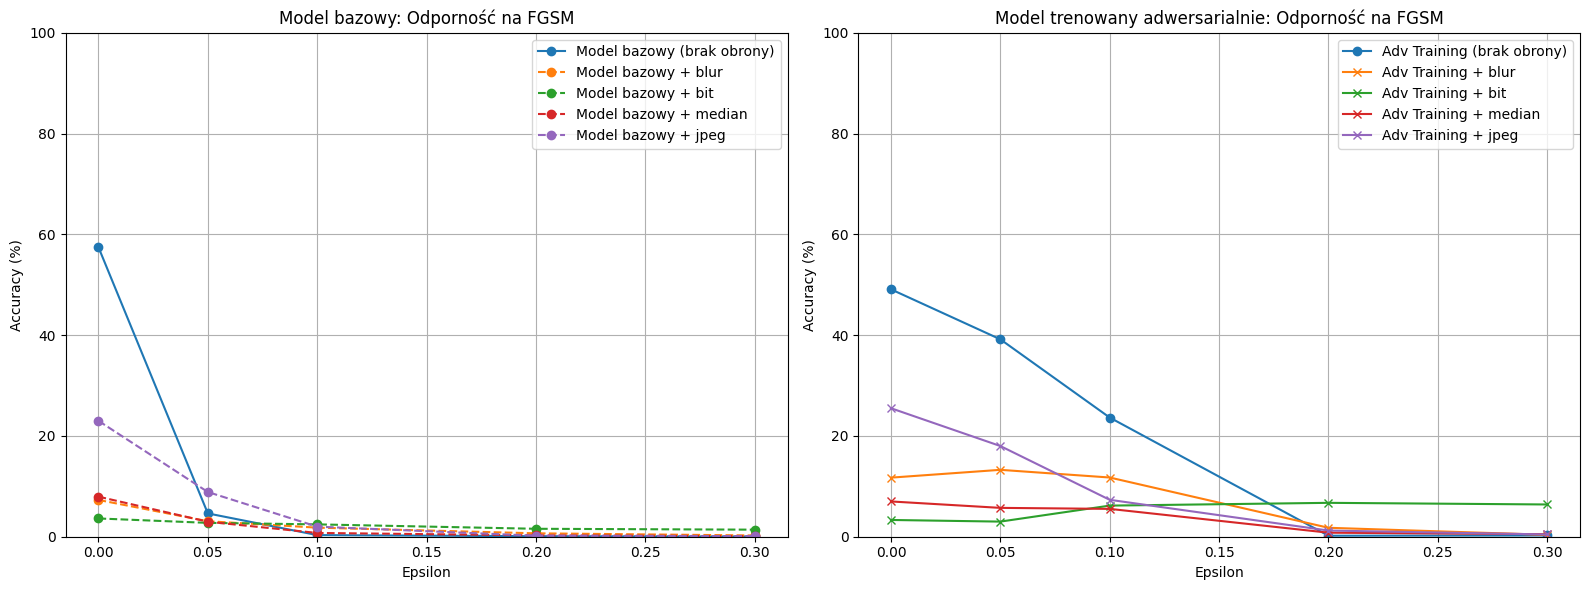

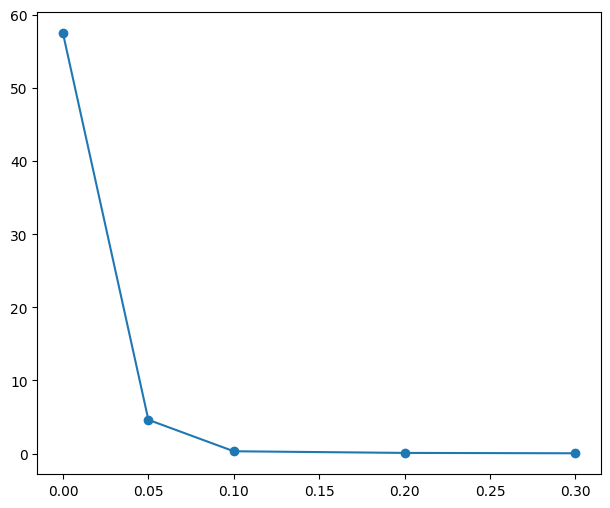

In [15]:
########################################################################################

# WYKRESY

########################################################################################


plt.figure(figsize=(16, 6))

# Wykres dla modelu bazowego (bez i z obroną)
plt.subplot(1, 2, 1)
plt.ylim(0, 100)
plt.plot(epsilons, base_model_fgsm_accuracies_no_def, marker='o', label='Model bazowy (brak obrony)')
for defense, accs in base_model_fgsm_defense_accuracies.items():
    plt.plot(epsilons, accs, marker='o', linestyle='--', label=f'Model bazowy + {defense}')
plt.title("Model bazowy: Odporność na FGSM")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Wykres dla modelu trenowanego adwersarialnie (bez i z obroną)
plt.subplot(1, 2, 2)
plt.ylim(0, 100)
plt.plot(epsilons, adv_trained_model_fgsm_acc_no_def, marker='o', label='Adv Training (brak obrony)')
for defense, accs in adv_trained_fgsm_defense_accuracies.items():
    plt.plot(epsilons, accs, marker='x', linestyle='-', label=f'Adv Training + {defense}')
plt.title("Model trenowany adwersarialnie: Odporność na FGSM")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()



# Wizualizacja działania ataku i obrony dla różnych metod
# Każdy z poniższych wykresów pokazuje oryginalny obraz, obraz po ataku FGSM oraz obraz po zastosowaniu danej metody obrony.
visualize_attack_and_defense(base_model, device, epsilon=0.2, defense=None)  # Bez obrony
visualize_attack_and_defense(base_model, device, epsilon=0.2, defense='blur')  # Obrona: Gaussian Blur
visualize_attack_and_defense(base_model, device, epsilon=0.2, defense='bit')  # Obrona: Bit-depth Reduction
visualize_attack_and_defense(base_model, device, epsilon=0.2, defense='median')  # Obrona: Median Filter
visualize_attack_and_defense(base_model, device, epsilon=0.2, defense='jpeg')  # Obrona: JPEG Compression


# Wizualizacja działania PGD + obrony
visualize_attack_and_defense(base_model, device, epsilon=0.2, defense=None, attack_type='pgd')
visualize_attack_and_defense(base_model, device, epsilon=0.2, defense='blur', attack_type='pgd')
visualize_attack_and_defense(base_model, device, epsilon=0.2, defense='bit', attack_type='pgd')
visualize_attack_and_defense(base_model, device, epsilon=0.2, defense='median', attack_type='pgd')
visualize_attack_and_defense(base_model, device, epsilon=0.2, defense='jpeg', attack_type='pgd')


# ======== PORÓWNANIE: FGSM vs PGD ========
plt.figure(figsize=(16, 6))

# Model bazowy - porównanie bez obrony
plt.subplot(1, 2, 1)
plt.plot(epsilons, base_model_fgsm_accuracies_no_def, marker='o', label='FGSM (brak obrony)')
plt.plot(epsilons, base_model_pgd_accuracies_no_def, marker='x', label='PGD (brak obrony)')
plt.title("Model bazowy: porównanie ataków bez obrony")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

# Model bazowy - porównanie z obroną
plt.subplot(1, 2, 2)
for defense in defenses:
    plt.plot(epsilons, base_model_fgsm_defense_accuracies[defense], marker='o', linestyle='--', label=f'FGSM + {defense}')
    plt.plot(epsilons, base_model_pgd_defense_accuracies[defense], marker='x', linestyle='-', label=f'PGD + {defense}')
plt.title("Model bazowy: porównanie ataków z obroną")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

plt.tight_layout()


# ======== PORÓWNANIE: FGSM vs PGD (model adwersarialny) ========
plt.figure(figsize=(16, 6))

# Adversarial model - porównanie bez obrony
# fgsm
# pgd
plt.subplot(1, 2, 1)
plt.plot(epsilons, adv_trained_model_fgsm_acc_no_def, marker='o', label='FGSM (Adv Training)')
plt.plot(epsilons, adv_trained_model_pgd_acc_no_def, marker='x', label='PGD (Adv Training)')
plt.title("Model trenowany ADV: porównanie ataków bez obrony")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

# Adversarial model - porównanie z obroną
plt.subplot(1, 2, 2)
for defense in defenses:
    plt.plot(epsilons, adv_trained_pgd_defense_accuracies[defense], marker='o', linestyle='--', label=f'PGD + {defense}')
plt.title("Model trenowany ADV: porównanie ataków z obroną")
for defense in defenses:
    plt.plot(epsilons, adv_trained_fgsm_defense_accuracies[defense], marker='x', linestyle='-', label=f'FGSM + {defense}')
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

plt.tight_layout()


# Wyświetlenie wykresów
plt.show(block=False)

plt.show()

In [ ]:
########################################################################################

# EKSPORT DANYCH: CSV + ROBUST ACCURACY + DEGRADACJA

########################################################################################
import pandas as pd

rows = []
for i, eps in enumerate(epsilons):
    row = {
        'epsilon': eps,
        'fgsm_no_defense': base_model_fgsm_accuracies_no_def[i],
        'pgd_no_defense': base_model_pgd_accuracies_no_def[i],
        'adv_fgsm_no_defense': adv_trained_model_fgsm_acc_no_def[i],
    }
    for defense in defenses:
        row[f'fgsm_{defense}'] = base_model_fgsm_defense_accuracies[defense][i]
        row[f'pgd_{defense}'] = base_model_pgd_defense_accuracies[defense][i]
        row[f'adv_fgsm_{defense}'] = adv_trained_fgsm_defense_accuracies[defense][i]
        row[f'adv_pgd_{defense}'] = adv_trained_pgd_defense_accuracies[defense][i]
    rows.append(row)



df = pd.DataFrame(rows)

robust_metrics = {
    'FGSM_no_defense': df['fgsm_no_defense'].mean(),
    'PGD_no_defense': df['pgd_no_defense'].mean(),
}
for defense in defenses:
    robust_metrics[f'FGSM_{defense}'] = df[f'fgsm_{defense}'].mean()
    robust_metrics[f'PGD_{defense}'] = df[f'pgd_{defense}'].mean()

robust_df = pd.DataFrame.from_dict(robust_metrics, orient='index', columns=['Robust Accuracy'])

baseline_clean = base_model_fgsm_accuracies_no_def[0]
pgd_clean = base_model_pgd_accuracies_no_def[0]
degradation_rows = []
for i, eps in enumerate(epsilons[1:]):
    idx = i + 1
    degradation_rows.append({
        'epsilon': eps,
        'fgsm_drop': baseline_clean - base_model_fgsm_accuracies_no_def[idx],
        'pgd_drop': pgd_clean - base_model_pgd_accuracies_no_def[idx],
    })
degradation_df = pd.DataFrame(degradation_rows)

output_dir = r"C:\PYTHON\wm_proj_drugi_dataset\eksport_wyników"
os.makedirs(output_dir, exist_ok=True)

df.to_csv(os.path.join(output_dir, "wyniki_szczegolowe.csv"), index=False)
robust_df.to_csv(os.path.join(output_dir, "robust_accuracy.csv"))
degradation_df.to_csv(os.path.join(output_dir, "degradacja_skutecznosci.csv"))

print(f"\nWyniki wyeksportowano do: {output_dir}")


Wyniki wyeksportowano do: C:\PYTHON\WM_proj\eksport_wyników


In [24]:

batch_visualize_attack_and_defense(base_model, device, epsilons=[0.05, 0.1, 0.2], indices=[0, 1, 2], defense='blur', attack_type='fgsm')
batch_visualize_attack_and_defense(base_model, device, epsilons=[0.05, 0.1, 0.2], indices=[3, 4, 5], defense='bit', attack_type='fgsm')
batch_visualize_attack_and_defense(base_model, device, epsilons=[0.05, 0.1, 0.2], indices=[6, 7, 8], defense='median', attack_type='fgsm')
batch_visualize_attack_and_defense(base_model, device, epsilons=[0.05, 0.1, 0.2], indices=[0, 1], defense='jpeg', attack_type='fgsm')

batch_visualize_attack_and_defense(base_model, device, epsilons=[0.05, 0.2], indices=[2, 3], defense='blur', attack_type='pgd')
batch_visualize_attack_and_defense(base_model, device, epsilons=[0.05, 0.2], indices=[7, 8], defense='bit', attack_type='pgd')
batch_visualize_attack_and_defense(base_model, device, epsilons=[0.05, 0.2], indices=[3, 4], defense='median', attack_type='pgd')
batch_visualize_attack_and_defense(base_model, device, epsilons=[0.05, 0.2], indices=[5, 6], defense='jpeg', attack_type='pgd')


Zapisano: idx0_eps0.05_atkfgsm_blur.png
Zapisano: idx0_eps0.1_atkfgsm_blur.png
Zapisano: idx0_eps0.2_atkfgsm_blur.png
Zapisano: idx1_eps0.05_atkfgsm_blur.png
Zapisano: idx1_eps0.1_atkfgsm_blur.png
Zapisano: idx1_eps0.2_atkfgsm_blur.png
Zapisano: idx2_eps0.05_atkfgsm_blur.png
Zapisano: idx2_eps0.1_atkfgsm_blur.png
Zapisano: idx2_eps0.2_atkfgsm_blur.png
Zapisano: idx3_eps0.05_atkfgsm_bit.png
Zapisano: idx3_eps0.1_atkfgsm_bit.png
Zapisano: idx3_eps0.2_atkfgsm_bit.png
Zapisano: idx4_eps0.05_atkfgsm_bit.png
Zapisano: idx4_eps0.1_atkfgsm_bit.png
Zapisano: idx4_eps0.2_atkfgsm_bit.png
Zapisano: idx5_eps0.05_atkfgsm_bit.png
Zapisano: idx5_eps0.1_atkfgsm_bit.png
Zapisano: idx5_eps0.2_atkfgsm_bit.png
Zapisano: idx6_eps0.05_atkfgsm_median.png
Zapisano: idx6_eps0.1_atkfgsm_median.png
Zapisano: idx6_eps0.2_atkfgsm_median.png
Zapisano: idx7_eps0.05_atkfgsm_median.png
Zapisano: idx7_eps0.1_atkfgsm_median.png
Zapisano: idx7_eps0.2_atkfgsm_median.png
Zapisano: idx8_eps0.05_atkfgsm_median.png
Zapisano: i

In [8]:

grid_search_defense_params(base_model, 'base_model', device, test_loader, attack_type='fgsm')
grid_search_defense_params(adv_trained_model, 'adv_model', device, test_loader, attack_type='fgsm')
"""
grid_search_defense_params(base_model, 'base_model', device, test_loader, attack_type='pgd')
grid_search_defense_params(adv_trained_model, 'adv_model', device, test_loader, attack_type='pgd')
"""

Zapisano wyniki grid search do pliku: C:\PYTHON\wm_proj_drugi_dataset\obrazy_zapisane\grid_search_base_model_fgsm.csv
Zapisano wyniki grid search do pliku: C:\PYTHON\wm_proj_drugi_dataset\obrazy_zapisane\grid_search_adv_model_fgsm.csv


"\ngrid_search_defense_params(base_model, 'base_model', device, test_loader, attack_type='pgd')\ngrid_search_defense_params(adv_trained_model, 'adv_model', device, test_loader, attack_type='pgd')\n"

In [26]:
base_model_fgsm_defense_accuracies_combos = {}
base_model_pgd_defense_accuracies_combos = {}
adv_trained_fgsm_defense_accuracies_combos = {}
adv_trained_pgd_defense_accuracies_combos = {}


defenses_combos = [
    
    ('median', 'blur'),
    ('jpeg', 'bit'),
    ('jpeg', 'median'),
    ('blur', 'jpeg'),
    ('median', 'bit'),
    ('bit', 'blur'),
    ]

In [27]:
for combo in defenses_combos:
    print(f"\nBazowy model + atak FGSM + Obrona: {combo}")
    accs = []
    for eps in epsilons:
        acc = test_defense_combo(
            model=base_model,
            device=device,
            test_loader=test_loader,
            epsilon=eps,
            defense_combo=combo,
            attack_type='fgsm'
        )
        accs.append(acc)
    base_model_fgsm_defense_accuracies_combos[tuple(combo)] = accs

for combo in defenses_combos:
    print(f"\nBazowy model + atak PGD + Obrona: {combo}")
    accs = []
    for eps in epsilons:
        acc = test_defense_combo(
            model=base_model,
            device=device,
            test_loader=test_loader,
            epsilon=eps,
            defense_combo=combo,
            attack_type='pgd'
        )
        accs.append(acc)
    base_model_pgd_defense_accuracies_combos[tuple(combo)] = accs

for combo in defenses_combos:
    print(f"\nModel trenowany ADV model + atak FGSM + Obrona: {combo}")
    accs = []
    for eps in epsilons:
        acc = test_defense_combo(
            model=adv_trained_model,
            device=device,
            test_loader=test_loader,
            epsilon=eps,
            defense_combo=combo,
            attack_type='fgsm'
        )
        accs.append(acc)
    adv_trained_fgsm_defense_accuracies_combos[tuple(combo)] = accs

for combo in defenses_combos:
    print(f"\nModel trenowany ADV model + atak PGD + Obrona: {combo}")
    accs = []
    for eps in epsilons:
        acc = test_defense_combo(
            model=adv_trained_model,
            device=device,
            test_loader=test_loader,
            epsilon=eps,
            defense_combo=combo,
            attack_type='pgd'
        )
        accs.append(acc)
    adv_trained_pgd_defense_accuracies_combos[tuple(combo)] = accs


Bazowy model + atak FGSM + Obrona: ('median', 'blur')
Acc dla ('median', 'blur') (ε=0, attack=fgsm): 83.87%
Acc dla ('median', 'blur') (ε=0.05, attack=fgsm): 79.87%
Acc dla ('median', 'blur') (ε=0.1, attack=fgsm): 74.05%
Acc dla ('median', 'blur') (ε=0.2, attack=fgsm): 55.42%
Acc dla ('median', 'blur') (ε=0.3, attack=fgsm): 33.54%

Bazowy model + atak FGSM + Obrona: ('jpeg', 'bit')
Acc dla ('jpeg', 'bit') (ε=0, attack=fgsm): 97.62%
Acc dla ('jpeg', 'bit') (ε=0.05, attack=fgsm): 95.73%
Acc dla ('jpeg', 'bit') (ε=0.1, attack=fgsm): 92.70%
Acc dla ('jpeg', 'bit') (ε=0.2, attack=fgsm): 79.99%
Acc dla ('jpeg', 'bit') (ε=0.3, attack=fgsm): 53.77%

Bazowy model + atak FGSM + Obrona: ('jpeg', 'median')
Acc dla ('jpeg', 'median') (ε=0, attack=fgsm): 94.33%
Acc dla ('jpeg', 'median') (ε=0.05, attack=fgsm): 90.93%
Acc dla ('jpeg', 'median') (ε=0.1, attack=fgsm): 86.32%
Acc dla ('jpeg', 'median') (ε=0.2, attack=fgsm): 71.13%
Acc dla ('jpeg', 'median') (ε=0.3, attack=fgsm): 46.44%

Bazowy model + 

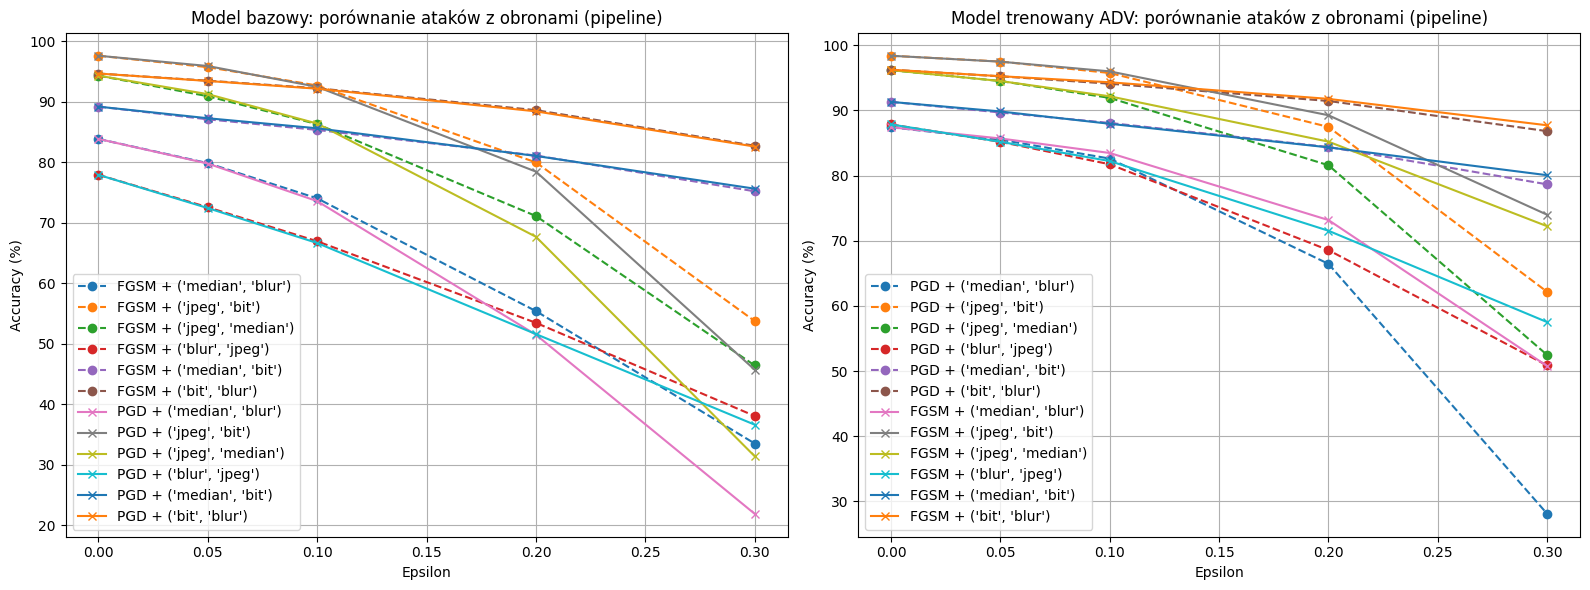

In [29]:
plt.figure(figsize=(16, 6))

# 1️⃣ Model bazowy - porównanie z obronami (pipeline)
plt.subplot(1, 2, 1)
for combo, accs in base_model_fgsm_defense_accuracies_combos.items():
    plt.plot(epsilons, accs, marker='o', linestyle='--', label=f'FGSM + {combo}')
for combo, accs in base_model_pgd_defense_accuracies_combos.items():
    plt.plot(epsilons, accs, marker='x', linestyle='-', label=f'PGD + {combo}')
plt.title("Model bazowy: porównanie ataków z obronami (pipeline)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()

# 2️⃣ Model trenowany adwersarialnie - porównanie z obronami (pipeline)
plt.subplot(1, 2, 2)
for combo, accs in adv_trained_pgd_defense_accuracies_combos.items():
    plt.plot(epsilons, accs, marker='o', linestyle='--', label=f'PGD + {combo}')
for combo, accs in adv_trained_fgsm_defense_accuracies_combos.items():
    plt.plot(epsilons, accs, marker='x', linestyle='-', label=f'FGSM + {combo}')
plt.title("Model trenowany ADV: porównanie ataków z obronami (pipeline)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()


plt.show(block=False)
plt.show()

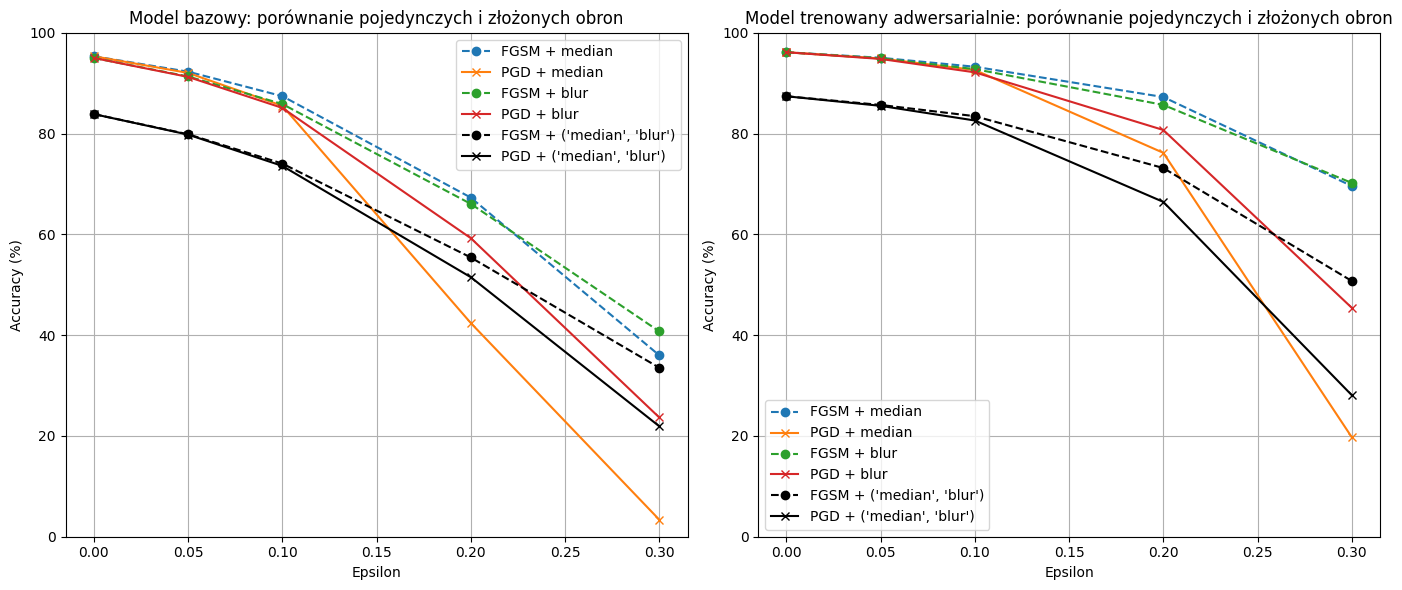

In [ ]:
plt.figure(figsize=(12, 6))

# Pojedyncze obrony (przykład dla bazowego modelu)
defenses = ['median', 'blur']
for defense in defenses:
    plt.plot(epsilons, base_model_fgsm_defense_accuracies[defense], marker='o', linestyle='--', label=f'FGSM + {defense}')
    plt.plot(epsilons, base_model_pgd_defense_accuracies[defense], marker='x', linestyle='-', label=f'PGD + {defense}')

# Pipeline: 'median + blur'
combo = ('median', 'blur')
plt.plot(epsilons, base_model_fgsm_defense_accuracies_combos[combo], marker='o', linestyle='--', color='black', label=f'FGSM + {combo}')
plt.plot(epsilons, base_model_pgd_defense_accuracies_combos[combo], marker='x', linestyle='-', color='black', label=f'PGD + {combo}')

plt.title("Model bazowy: porównanie pojedynczych i złożonych obron")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
plt.figure(figsize=(14, 6))

########## 1️⃣ Model bazowy ##########
plt.subplot(1, 2, 1)

# Pojedyncze obrony
defenses = ['median', 'blur']
for defense in defenses:
    plt.plot(epsilons, base_model_fgsm_defense_accuracies[defense], marker='o', linestyle='--', label=f'FGSM + {defense}')
    plt.plot(epsilons, base_model_pgd_defense_accuracies[defense], marker='x', linestyle='-', label=f'PGD + {defense}')

# Pipeline: 'median + blur'
combo = ('median', 'blur')
plt.plot(epsilons, base_model_fgsm_defense_accuracies_combos[combo], marker='o', linestyle='--', color='black', label=f'FGSM + {combo}')
plt.plot(epsilons, base_model_pgd_defense_accuracies_combos[combo], marker='x', linestyle='-', color='black', label=f'PGD + {combo}')

plt.title("Model bazowy: porównanie pojedynczych i złożonych obron")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.tight_layout()

########## 2️⃣ Model trenowany adwersarialnie ##########
plt.subplot(1, 2, 2)

for defense in defenses:
    plt.plot(epsilons, adv_trained_fgsm_defense_accuracies[defense], marker='o', linestyle='--', label=f'FGSM + {defense}')
    plt.plot(epsilons, adv_trained_pgd_defense_accuracies[defense], marker='x', linestyle='-', label=f'PGD + {defense}')

plt.plot(epsilons, adv_trained_fgsm_defense_accuracies_combos[combo], marker='o', linestyle='--', color='black', label=f'FGSM + {combo}')
plt.plot(epsilons, adv_trained_pgd_defense_accuracies_combos[combo], marker='x', linestyle='-', color='black', label=f'PGD + {combo}')

plt.title("Model trenowany adwersarialnie: porównanie pojedynczych i złożonych obron")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.tight_layout()

########## Wyświetlenie wykresu ##########
plt.show()


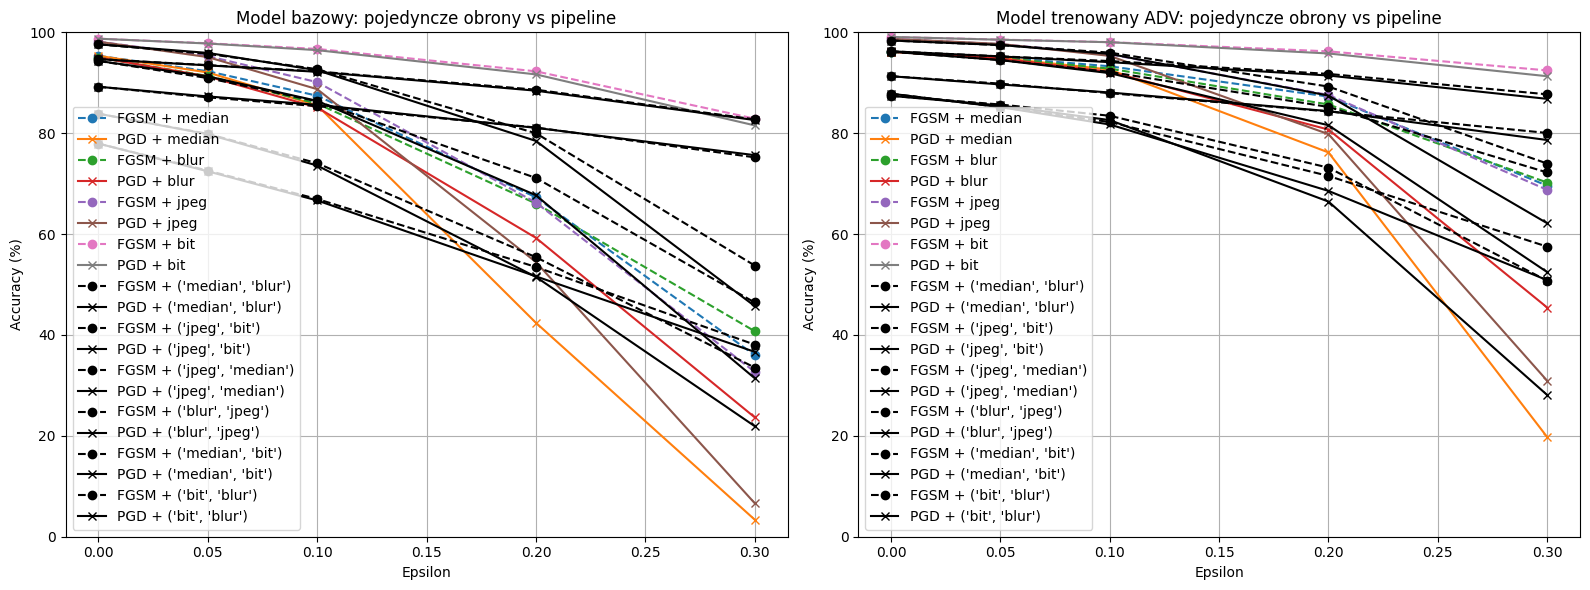

In [32]:
plt.figure(figsize=(16, 6))

# Lewy wykres: Model bazowy
plt.subplot(1, 2, 1)
# Pojedyncze obrony
single_defenses = ['median', 'blur', 'jpeg', 'bit']
for defense in single_defenses:
    plt.plot(epsilons, base_model_fgsm_defense_accuracies[defense], marker='o', linestyle='--', label=f'FGSM + {defense}')
    plt.plot(epsilons, base_model_pgd_defense_accuracies[defense], marker='x', linestyle='-', label=f'PGD + {defense}')

# Wszystkie pipeline
for combo in defenses_combos:
    color = 'black'  # pipeline w jednym kolorze, np. czarnym
    plt.plot(epsilons, base_model_fgsm_defense_accuracies_combos[combo], marker='o', linestyle='--', color=color, label=f'FGSM + {combo}')
    plt.plot(epsilons, base_model_pgd_defense_accuracies_combos[combo], marker='x', linestyle='-', color=color, label=f'PGD + {combo}')

plt.title("Model bazowy: pojedyncze obrony vs pipeline")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Prawy wykres: Model trenowany adwersarialnie
plt.subplot(1, 2, 2)
for defense in single_defenses:
    plt.plot(epsilons, adv_trained_fgsm_defense_accuracies[defense], marker='o', linestyle='--', label=f'FGSM + {defense}')
    plt.plot(epsilons, adv_trained_pgd_defense_accuracies[defense], marker='x', linestyle='-', label=f'PGD + {defense}')

for combo in defenses_combos:
    color = 'black'
    plt.plot(epsilons, adv_trained_fgsm_defense_accuracies_combos[combo], marker='o', linestyle='--', color=color, label=f'FGSM + {combo}')
    plt.plot(epsilons, adv_trained_pgd_defense_accuracies_combos[combo], marker='x', linestyle='-', color=color, label=f'PGD + {combo}')

plt.title("Model trenowany ADV: pojedyncze obrony vs pipeline")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()


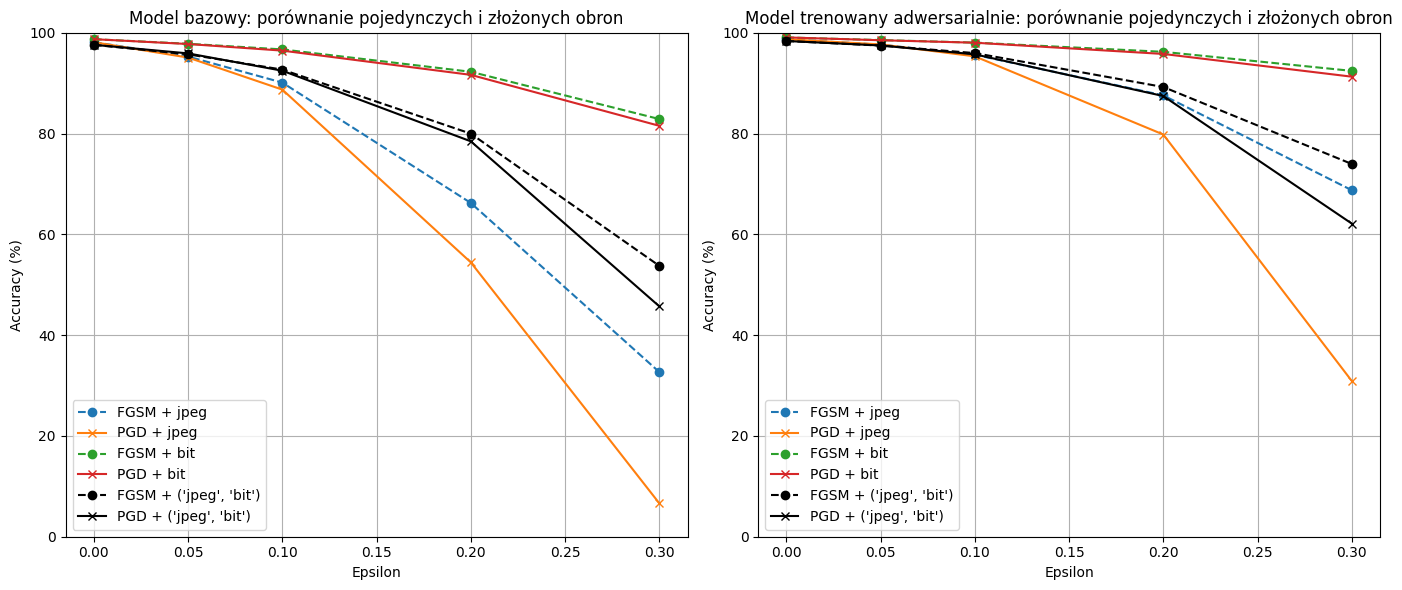

In [ ]:
plt.figure(figsize=(14, 6))

########## 1️⃣ Model bazowy ##########
plt.subplot(1, 2, 1)

# Pojedyncze obrony
defenses = ['jpeg', 'bit']
for defense in defenses:
    plt.plot(epsilons, base_model_fgsm_defense_accuracies[defense], marker='o', linestyle='--', label=f'FGSM + {defense}')
    plt.plot(epsilons, base_model_pgd_defense_accuracies[defense], marker='x', linestyle='-', label=f'PGD + {defense}')

# Pipeline: 'jpeg + bit'
combo = ('jpeg', 'bit')
plt.plot(epsilons, base_model_fgsm_defense_accuracies_combos[combo], marker='o', linestyle='--', color='black', label=f'FGSM + {combo}')
plt.plot(epsilons, base_model_pgd_defense_accuracies_combos[combo], marker='x', linestyle='-', color='black', label=f'PGD + {combo}')

plt.title("Model bazowy: porównanie pojedynczych i złożonych obron")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.tight_layout()

########## 2️⃣ Model trenowany adwersarialnie ##########
plt.subplot(1, 2, 2)

for defense in defenses:
    plt.plot(epsilons, adv_trained_fgsm_defense_accuracies[defense], marker='o', linestyle='--', label=f'FGSM + {defense}')
    plt.plot(epsilons, adv_trained_pgd_defense_accuracies[defense], marker='x', linestyle='-', label=f'PGD + {defense}')

plt.plot(epsilons, adv_trained_fgsm_defense_accuracies_combos[combo], marker='o', linestyle='--', color='black', label=f'FGSM + {combo}')
plt.plot(epsilons, adv_trained_pgd_defense_accuracies_combos[combo], marker='x', linestyle='-', color='black', label=f'PGD + {combo}')

plt.title("Model trenowany adwersarialnie: porównanie pojedynczych i złożonych obron")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.tight_layout()

########## Wyświetlenie wykresu ##########
plt.show()


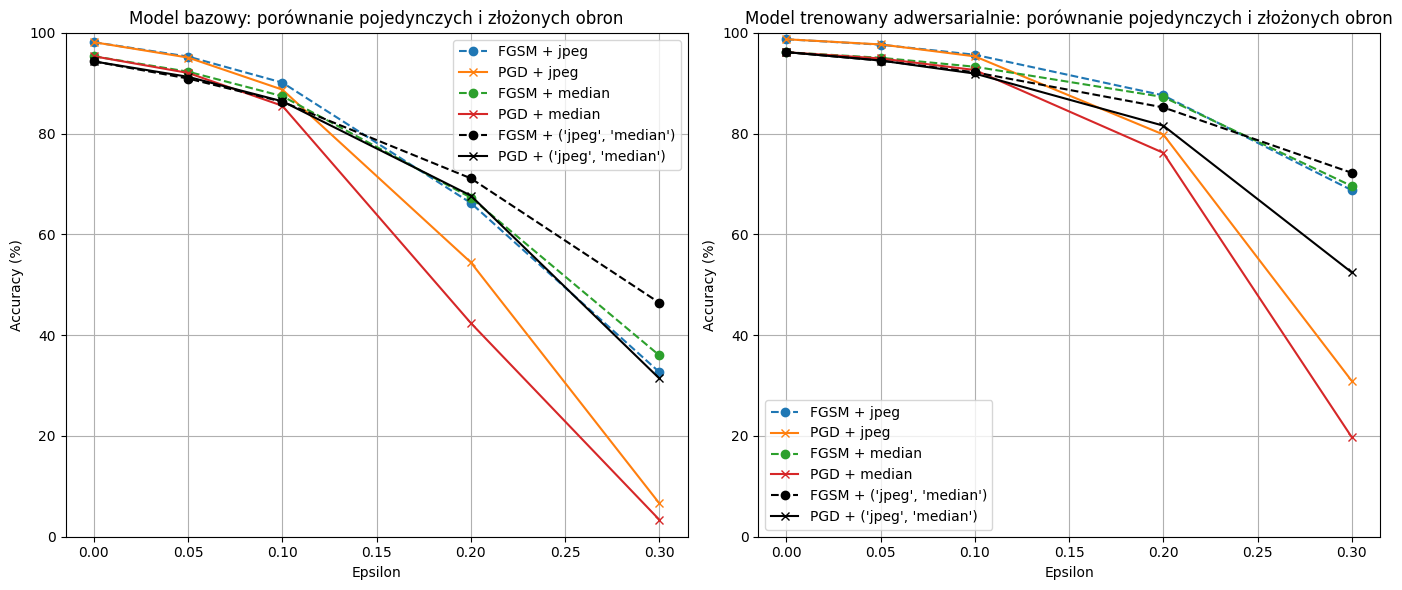

In [34]:
plt.figure(figsize=(14, 6))

########## 1️⃣ Model bazowy ##########
plt.subplot(1, 2, 1)

# Pojedyncze obrony
defenses = ['jpeg', 'median']
for defense in defenses:
    plt.plot(epsilons, base_model_fgsm_defense_accuracies[defense], marker='o', linestyle='--', label=f'FGSM + {defense}')
    plt.plot(epsilons, base_model_pgd_defense_accuracies[defense], marker='x', linestyle='-', label=f'PGD + {defense}')

# Pipeline: 'jpeg + median'
combo = ('jpeg', 'median')
plt.plot(epsilons, base_model_fgsm_defense_accuracies_combos[combo], marker='o', linestyle='--', color='black', label=f'FGSM + {combo}')
plt.plot(epsilons, base_model_pgd_defense_accuracies_combos[combo], marker='x', linestyle='-', color='black', label=f'PGD + {combo}')

plt.title("Model bazowy: porównanie pojedynczych i złożonych obron")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.tight_layout()

########## 2️⃣ Model trenowany adwersarialnie ##########
plt.subplot(1, 2, 2)

for defense in defenses:
    plt.plot(epsilons, adv_trained_fgsm_defense_accuracies[defense], marker='o', linestyle='--', label=f'FGSM + {defense}')
    plt.plot(epsilons, adv_trained_pgd_defense_accuracies[defense], marker='x', linestyle='-', label=f'PGD + {defense}')

plt.plot(epsilons, adv_trained_fgsm_defense_accuracies_combos[combo], marker='o', linestyle='--', color='black', label=f'FGSM + {combo}')
plt.plot(epsilons, adv_trained_pgd_defense_accuracies_combos[combo], marker='x', linestyle='-', color='black', label=f'PGD + {combo}')

plt.title("Model trenowany adwersarialnie: porównanie pojedynczych i złożonych obron")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.tight_layout()

########## Wyświetlenie wykresu ##########
plt.show()


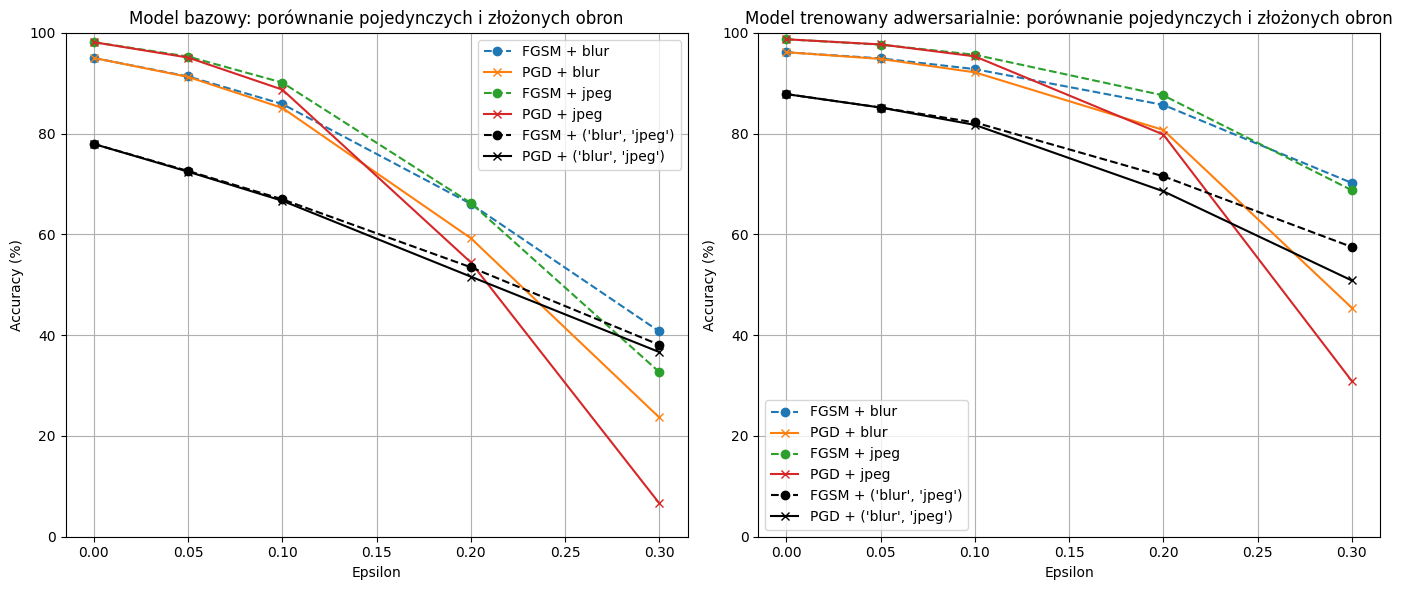

In [35]:
plt.figure(figsize=(14, 6))

########## 1️⃣ Model bazowy ##########
plt.subplot(1, 2, 1)

# Pojedyncze obrony
defenses = ['blur', 'jpeg']
for defense in defenses:
    plt.plot(epsilons, base_model_fgsm_defense_accuracies[defense], marker='o', linestyle='--', label=f'FGSM + {defense}')
    plt.plot(epsilons, base_model_pgd_defense_accuracies[defense], marker='x', linestyle='-', label=f'PGD + {defense}')

# Pipeline: 'blur + jpeg'
combo = ('blur', 'jpeg')
plt.plot(epsilons, base_model_fgsm_defense_accuracies_combos[combo], marker='o', linestyle='--', color='black', label=f'FGSM + {combo}')
plt.plot(epsilons, base_model_pgd_defense_accuracies_combos[combo], marker='x', linestyle='-', color='black', label=f'PGD + {combo}')

plt.title("Model bazowy: porównanie pojedynczych i złożonych obron")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.tight_layout()

########## 2️⃣ Model trenowany adwersarialnie ##########
plt.subplot(1, 2, 2)

for defense in defenses:
    plt.plot(epsilons, adv_trained_fgsm_defense_accuracies[defense], marker='o', linestyle='--', label=f'FGSM + {defense}')
    plt.plot(epsilons, adv_trained_pgd_defense_accuracies[defense], marker='x', linestyle='-', label=f'PGD + {defense}')

plt.plot(epsilons, adv_trained_fgsm_defense_accuracies_combos[combo], marker='o', linestyle='--', color='black', label=f'FGSM + {combo}')
plt.plot(epsilons, adv_trained_pgd_defense_accuracies_combos[combo], marker='x', linestyle='-', color='black', label=f'PGD + {combo}')

plt.title("Model trenowany adwersarialnie: porównanie pojedynczych i złożonych obron")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.tight_layout()

########## Wyświetlenie wykresu ##########
plt.show()


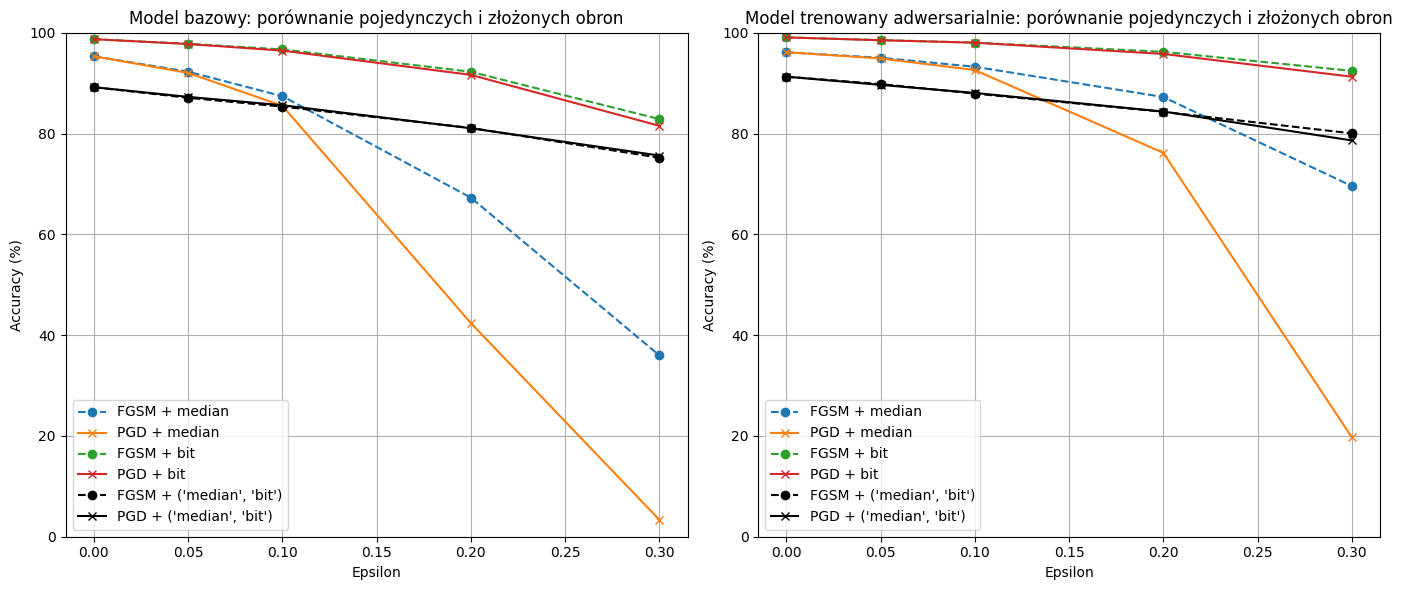

In [36]:
plt.figure(figsize=(14, 6))

########## 1️⃣ Model bazowy ##########
plt.subplot(1, 2, 1)

# Pojedyncze obrony
defenses = ['median', 'bit']
for defense in defenses:
    plt.plot(epsilons, base_model_fgsm_defense_accuracies[defense], marker='o', linestyle='--', label=f'FGSM + {defense}')
    plt.plot(epsilons, base_model_pgd_defense_accuracies[defense], marker='x', linestyle='-', label=f'PGD + {defense}')

# Pipeline: 'median + bit'
combo = ('median', 'bit')
plt.plot(epsilons, base_model_fgsm_defense_accuracies_combos[combo], marker='o', linestyle='--', color='black', label=f'FGSM + {combo}')
plt.plot(epsilons, base_model_pgd_defense_accuracies_combos[combo], marker='x', linestyle='-', color='black', label=f'PGD + {combo}')

plt.title("Model bazowy: porównanie pojedynczych i złożonych obron")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.tight_layout()

########## 2️⃣ Model trenowany adwersarialnie ##########
plt.subplot(1, 2, 2)

for defense in defenses:
    plt.plot(epsilons, adv_trained_fgsm_defense_accuracies[defense], marker='o', linestyle='--', label=f'FGSM + {defense}')
    plt.plot(epsilons, adv_trained_pgd_defense_accuracies[defense], marker='x', linestyle='-', label=f'PGD + {defense}')

plt.plot(epsilons, adv_trained_fgsm_defense_accuracies_combos[combo], marker='o', linestyle='--', color='black', label=f'FGSM + {combo}')
plt.plot(epsilons, adv_trained_pgd_defense_accuracies_combos[combo], marker='x', linestyle='-', color='black', label=f'PGD + {combo}')

plt.title("Model trenowany adwersarialnie: porównanie pojedynczych i złożonych obron")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.tight_layout()

########## Wyświetlenie wykresu ##########
plt.show()


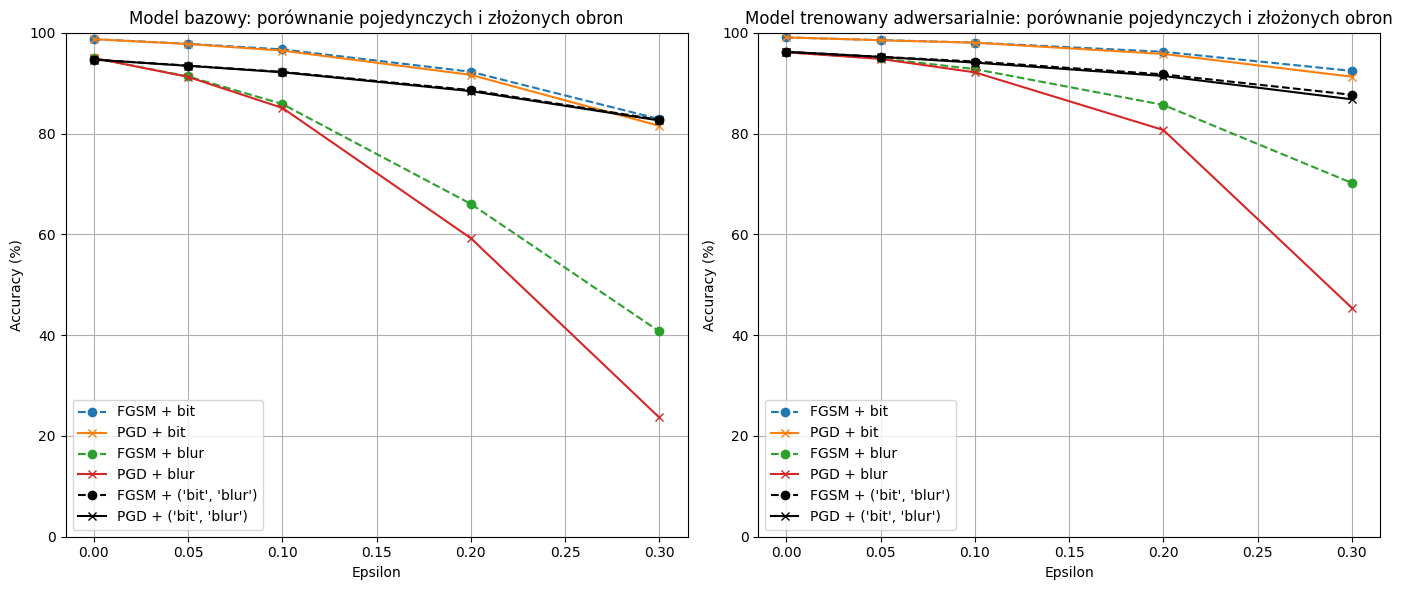

In [37]:
plt.figure(figsize=(14, 6))

########## 1️⃣ Model bazowy ##########
plt.subplot(1, 2, 1)

# Pojedyncze obrony
defenses = ['bit', 'blur']
for defense in defenses:
    plt.plot(epsilons, base_model_fgsm_defense_accuracies[defense], marker='o', linestyle='--', label=f'FGSM + {defense}')
    plt.plot(epsilons, base_model_pgd_defense_accuracies[defense], marker='x', linestyle='-', label=f'PGD + {defense}')

# Pipeline: 'bit + blur'
combo = ('bit', 'blur')
plt.plot(epsilons, base_model_fgsm_defense_accuracies_combos[combo], marker='o', linestyle='--', color='black', label=f'FGSM + {combo}')
plt.plot(epsilons, base_model_pgd_defense_accuracies_combos[combo], marker='x', linestyle='-', color='black', label=f'PGD + {combo}')

plt.title("Model bazowy: porównanie pojedynczych i złożonych obron")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.tight_layout()

########## 2️⃣ Model trenowany adwersarialnie ##########
plt.subplot(1, 2, 2)

for defense in defenses:
    plt.plot(epsilons, adv_trained_fgsm_defense_accuracies[defense], marker='o', linestyle='--', label=f'FGSM + {defense}')
    plt.plot(epsilons, adv_trained_pgd_defense_accuracies[defense], marker='x', linestyle='-', label=f'PGD + {defense}')

plt.plot(epsilons, adv_trained_fgsm_defense_accuracies_combos[combo], marker='o', linestyle='--', color='black', label=f'FGSM + {combo}')
plt.plot(epsilons, adv_trained_pgd_defense_accuracies_combos[combo], marker='x', linestyle='-', color='black', label=f'PGD + {combo}')

plt.title("Model trenowany adwersarialnie: porównanie pojedynczych i złożonych obron")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.tight_layout()

########## Wyświetlenie wykresu ##########
plt.show()


In [6]:

# Wizualizacja działania ataku i obrony dla różnych metod
# Każdy z poniższych wykresów pokazuje oryginalny obraz, obraz po ataku FGSM oraz obraz po zastosowaniu danej metody obrony.
visualize_attack_and_defense(base_model, device, epsilon=0.2, defense=None)  # Bez obrony
visualize_attack_and_defense(base_model, device, epsilon=0.2, defense='blur')  # Obrona: Gaussian Blur
visualize_attack_and_defense(base_model, device, epsilon=0.2, defense='bit')  # Obrona: Bit-depth Reduction
visualize_attack_and_defense(base_model, device, epsilon=0.2, defense='median')  # Obrona: Median Filter
visualize_attack_and_defense(base_model, device, epsilon=0.2, defense='jpeg')  # Obrona: JPEG Compression


# Wizualizacja działania PGD + obrony
visualize_attack_and_defense(base_model, device, epsilon=0.2, defense=None, attack_type='pgd')
visualize_attack_and_defense(base_model, device, epsilon=0.2, defense='blur', attack_type='pgd')
visualize_attack_and_defense(base_model, device, epsilon=0.2, defense='bit', attack_type='pgd')
visualize_attack_and_defense(base_model, device, epsilon=0.2, defense='median', attack_type='pgd')
visualize_attack_and_defense(base_model, device, epsilon=0.2, defense='jpeg', attack_type='pgd')

Zapisano obraz do pliku: C:\PYTHON\wm_proj_drugi_dataset\obrazy_zapisane\visual_e0.2_none.png
Zapisano obraz do pliku: C:\PYTHON\wm_proj_drugi_dataset\obrazy_zapisane\visual_e0.2_blur.png
Zapisano obraz do pliku: C:\PYTHON\wm_proj_drugi_dataset\obrazy_zapisane\visual_e0.2_bit.png
Zapisano obraz do pliku: C:\PYTHON\wm_proj_drugi_dataset\obrazy_zapisane\visual_e0.2_median.png
Zapisano obraz do pliku: C:\PYTHON\wm_proj_drugi_dataset\obrazy_zapisane\visual_e0.2_jpeg.png
Zapisano obraz do pliku: C:\PYTHON\wm_proj_drugi_dataset\obrazy_zapisane\visual_e0.2_none.png
Zapisano obraz do pliku: C:\PYTHON\wm_proj_drugi_dataset\obrazy_zapisane\visual_e0.2_blur.png
Zapisano obraz do pliku: C:\PYTHON\wm_proj_drugi_dataset\obrazy_zapisane\visual_e0.2_bit.png
Zapisano obraz do pliku: C:\PYTHON\wm_proj_drugi_dataset\obrazy_zapisane\visual_e0.2_median.png
Zapisano obraz do pliku: C:\PYTHON\wm_proj_drugi_dataset\obrazy_zapisane\visual_e0.2_jpeg.png
